In [1]:
import numpy as np
import pandas as pd
import requests
import subprocess
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers

import keras


from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def metrics_evals(y_true,y_pred, X_test):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1-r2)*(len(y_true)-1)/(len(y_true)-X_test.shape[1]-1)

    return {"MSE":mse, 
            "RMSE":rmse, 
            "MAE":mae, 
            "R2":r2,
            "ADJ_R2": adj_r2}

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# For Reproducibility
np.random.seed(42)
tf.random.set_seed(42)



data_link = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/015/039/original/dataset.csv.zip?1663710760"



def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

download_url(url=data_link, save_path='data/dataset.zip')

# importing required modules
from zipfile import ZipFile

# specifying the zip file name
file_name = "my_python_files.zip"

# opening the zip file in READ mode
with ZipFile('data/dataset.zip', 'r') as zip:
	# printing all the contents of the zip file
	zip.printdir()

	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')


# moving the data to data folder
subprocess.run(['mv', 'dataset.csv', 'data'])

# removing the dataset.zip file from the data folder
subprocess.run(['rm', '-r', 'data/dataset.zip'])

2023-10-09 23:29:45.804120: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


File Name                                             Modified             Size
dataset.csv                                    2022-04-12 14:09:50     23759573
Extracting all the files now...
Done!


CompletedProcess(args=['rm', '-r', 'data/dataset.zip'], returncode=0)

## What Porter is all about?

Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers

Porter works with a wide range of restaurants for delivering their items directly to the people.



## Problem Statement

Porter seeks to estimate delivery times for its customers, taking into account a variety of factors such as the specific food items being ordered, their source restaurant, and the available delivery partners. Our objective is to develop a **delivery time estimation system** that incorporates these features.

## Dictionary

- market_id : integer id for the market where the restaurant lies
- created_at : the timestamp at which the order was placed
- actual_delivery_time : the timestamp when the order was delivered
- store_primary_category : category for the restaurant
- order_protocol : integer code value for order protocol(how the order was placed ie: through porter, call to restaurant, pre booked, third part etc)
- total_items subtotal : final price of the order
- num_distinct_items : the number of distinct items in the order
- min_item_price : price of the cheapest item in the order
- max_item_price : price of the costliest item in order
- total_onshift_partners : number of delivery partners on duty at the time order was placed
- total_busy_partners : number of delivery partners attending to other tasks
- total_outstanding_orders : total number of orders to be fulfilled at the moment

In [2]:

df = pd.read_csv("data/dataset.csv", date_format=['created_at', 'actual_delivery_time'], parse_dates=True)
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

df['Hour_of_day'] = df['created_at'].dt.hour

df['day_of_week'] = df['created_at'].dt.day_of_week

df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,22,4
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,21,1
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,20,3
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,21,1
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,2,6


In [3]:
alpha = 0.05
def null_checker(p, alpha =0.05):
    
    # Hypothesis significance checker code
    if p<alpha:
        print("Reject the null hypothesis")
    else:
        print("Failed to Reject the null hypothesis")

def qq_plot(x):
    # Code to draw qqplots for univariate analysis
    m = x.name
    fig = plt.figure()
    ax = fig.add_subplot(111)
    x = x.to_list()
    res = stats.probplot(x, dist=stats.norm, plot=ax)
    
    ax.set_title(f"Probplot for normal dist for {m}")

In [4]:
df.info()
# market_id, actual_delivery_time, store_primary_category, order_protocol, total_onshift_partners, total_busy_partners, total_outstanding_orders have missing values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 196441 non-null  float64       
 1   created_at                197428 non-null  datetime64[ns]
 2   actual_delivery_time      197421 non-null  datetime64[ns]
 3   store_id                  197428 non-null  object        
 4   store_primary_category    192668 non-null  object        
 5   order_protocol            196433 non-null  float64       
 6   total_items               197428 non-null  int64         
 7   subtotal                  197428 non-null  int64         
 8   num_distinct_items        197428 non-null  int64         
 9   min_item_price            197428 non-null  int64         
 10  max_item_price            197428 non-null  int64         
 11  total_onshift_partners    181166 non-null  float64       
 12  to

In [5]:
##Find uniques values for each feature
df.nunique()

market_id                        6
created_at                  180985
actual_delivery_time        178110
store_id                      6743
store_primary_category          74
order_protocol                   7
total_items                     57
subtotal                      8368
num_distinct_items              20
min_item_price                2312
max_item_price                2652
total_onshift_partners         172
total_busy_partners            159
total_outstanding_orders       281
Hour_of_day                     19
day_of_week                      7
dtype: int64

In [6]:
##Checking Duplicated values in dataset
df.duplicated().sum()

0

In [7]:
# Percentage of missing values
round(df.isna().sum()*100/df.shape[0], 2)

market_id                   0.50
created_at                  0.00
actual_delivery_time        0.00
store_id                    0.00
store_primary_category      2.41
order_protocol              0.50
total_items                 0.00
subtotal                    0.00
num_distinct_items          0.00
min_item_price              0.00
max_item_price              0.00
total_onshift_partners      8.24
total_busy_partners         8.24
total_outstanding_orders    8.24
Hour_of_day                 0.00
day_of_week                 0.00
dtype: float64

In [8]:
df.dtypes

market_id                          float64
created_at                  datetime64[ns]
actual_delivery_time        datetime64[ns]
store_id                            object
store_primary_category              object
order_protocol                     float64
total_items                          int64
subtotal                             int64
num_distinct_items                   int64
min_item_price                       int64
max_item_price                       int64
total_onshift_partners             float64
total_busy_partners                float64
total_outstanding_orders           float64
Hour_of_day                          int32
day_of_week                          int32
dtype: object

## Types of Columns

1. Quantitative
- total_items: Total number of food items in the final order
- subtotal: Final order price
- num_distinct_items: Number of distinct food items in the order
- min_item_price: The cheapest item price in the order
- max_item_price: The most expensive item price in the order
- total_onshift_partners: Number of delivery partners working at the time of order
- total_busy_partners: Number of delivery partners engaged in other tasks
- total_outstanding_orders: Total number of orders currently being processed

2. Dates

- created_at: Time of order placement
- actual_delivery_time: Time of order delivery

3. Categorical

- order_protocol: Method of order placement (e.g., phone, pre-order)
- store_primary_category: Primary category of the restaurant

4. Identifiers

- market_id: Market identifier where the restaurant is located
- store_id: Restaurant category

## Exploratory Data Analysis

### Feature Engineering

In [9]:
# Calculate the difference between two date columns (converted to minutes)
df['del_time'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

In [10]:
df['min_max_avg_item_price'] = (df['min_item_price'] + df['max_item_price']) / 2

In [11]:
df['store_id'].nunique()

6743

In [12]:
stores_unknown_market_id_list = df.loc[df['market_id'].isna(), 'store_id'].unique()

In [13]:
df.loc[(~df['market_id'].isna()) & (df['store_id']), "market_id"]

0         1.0
1         2.0
2         3.0
3         3.0
4         3.0
         ... 
197423    1.0
197424    1.0
197425    1.0
197426    1.0
197427    1.0
Name: market_id, Length: 196441, dtype: float64

In [14]:
# created a store to market id mapping
df.groupby('store_id')['market_id'].unique().to_dict()


# Observation here is that multiple stores can service more than one market. Hence, no point making vague imputations. Its better to drop these identifier columns.


{'0004d0b59e19461ff126e3a08a814c33': array([ 4., nan,  1.,  3.]),
 '00053f5e11d1fe4e49a221165b39abc9': array([3.]),
 '0006aabe0ba47a35c0b0bf6596f85159': array([3.]),
 '000a91f3e374e6147d58ed1814247508': array([3.]),
 '0029f088c57ad3b6ec589f9ba4f7a057': array([3., 1.]),
 '002f9c8cee878b64a747a2c211da7d83': array([5., 1.]),
 '00430c0c1fae276c9713ab5f21167882': array([ 1.,  3.,  4., nan,  6.,  2.,  5.]),
 '0044deeec43ded19b952125079eb1781': array([1.]),
 '00482b9bed15a272730fcb590ffebddd': array([6., 1.]),
 '004a68efcee088ddeaaca5c5a3afaa2f': array([3.]),
 '005b0c27e7224dabb8c1c7346ceea228': array([1.]),
 '005f91955ff9fc532184ba7566f088fd': array([3.]),
 '0060ef47b12160b9198302ebdb144dcf': array([1.]),
 '00650747d878eecae4d468a880de38b2': array([4., 5., 2., 1., 3.]),
 '006bfae3a90bab38e29382170867e962': array([3.]),
 '006f52e9102a8d3be2fe5614f42ba989': array([2.]),
 '0070d23b06b1486a538c0eaa45dd167a': array([4., 2.]),
 '007202387c4274c570d9cb72943fc873': array([2.]),
 '00755a54ea07fa69087

In [15]:
df.groupby('market_id')['store_id'].unique().to_dict()

{1.0: array(['df263d996281d984952c07998dc54358',
        'ef1e491a766ce3127556063d49bc2f98',
        'ce016f59ecc2366a43e1c96a4774d167', ...,
        'ce78d1da254c0843eb23951ae077ff5f',
        'a914ecef9c12ffdb9bede64bb703d877',
        'c81e155d85dae5430a8cee6f2242e82c'], dtype=object),
 2.0: array(['f0ade77b43923b38237db569b016ba25',
        '50905d7b2216bfeccb5b41016357176b',
        '0738069b244a1c43c83112b735140a16', ...,
        'fd8bd77225ce96b0a96239fe8481f208',
        '4b04a686b0ad13dce35fa99fa4161c65',
        'a914ecef9c12ffdb9bede64bb703d877'], dtype=object),
 3.0: array(['f0ade77b43923b38237db569b016ba25',
        '50905d7b2216bfeccb5b41016357176b',
        '0738069b244a1c43c83112b735140a16', ...,
        '084afd913ab1e6ea58b8ca73f6cb41a6',
        '6ce8d8f3b038f737cefcdafcf3752452',
        '959776b99b006e5785c3a3364949ce47'], dtype=object),
 4.0: array(['ea119a40c1592979f51819b0bd38d39d',
        '0738069b244a1c43c83112b735140a16',
        '67f7fb873eaf29526a11a9b7ac33

In [16]:
# Drop unnecessary columns
df.drop(labels=['market_id', 'store_id', 'created_at', 'actual_delivery_time'], axis=1, inplace=True)

In [17]:
# There is no point keeping empty target values
df.drop(index=df.loc[df.del_time.isna()].index, inplace=True)

In [18]:
df.head()

,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week,del_time,min_max_avg_item_price
0,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,22,4,62.983333,898.0
1,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,21,1,67.066667,1400.0
2,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,20,3,29.683333,1900.0
3,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,21,1,51.250000,1200.0
4,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,2,6,39.833333,1350.0


In [19]:
df.loc[(df.order_protocol==1.0) & (df.total_items.isin([1, 2]))]

,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week,del_time,min_max_avg_item_price
2,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,20,3,29.683333,1900.0
6,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,2,5,26.400000,1950.0
9,NaN,1.0,2,2100,2,700,1200,2.0,2.0,2.0,1,2,53.200000,950.0
11,NaN,1.0,2,2200,2,600,1600,3.0,3.0,4.0,4,0,134.450000,1100.0
12,NaN,1.0,1,1900,1,1900,1900,6.0,3.0,3.0,1,5,42.716667,1900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197343,italian,1.0,2,2397,2,999,1099,15.0,15.0,17.0,20,0,48.216667,1049.0
197344,italian,1.0,2,2675,2,299,1499,5.0,7.0,8.0,23,3,62.250000,899.0
197345,italian,1.0,2,2996,1,1099,1099,22.0,22.0,26.0,3,2,56.233333,1099.0
197346,italian,1.0,2,2448,2,1199,1249,7.0,9.0,21.0,4,3,51.766667,1224.0


In [20]:
df.loc[(df.order_protocol.isna()) & (df.total_items==1)]

,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week,del_time,min_max_avg_item_price
1140,NaN,NaN,1,1995,1,1995,1995,14.0,10.0,12.0,20,4,50.233333,1995.0
1625,pizza,NaN,1,1699,1,1399,1399,44.0,40.0,69.0,3,1,31.683333,1399.0
2382,NaN,NaN,1,2575,1,2575,2575,55.0,54.0,89.0,2,0,38.800000,2575.0
3545,pizza,NaN,1,995,1,695,695,11.0,7.0,6.0,0,3,42.950000,695.0
4205,italian,NaN,1,1698,1,1698,1698,103.0,108.0,178.0,3,3,40.666667,1698.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188233,japanese,NaN,1,1100,1,1100,1100,0.0,0.0,0.0,5,6,69.916667,1100.0
189446,NaN,NaN,1,995,1,995,995,29.0,29.0,33.0,19,3,23.933333,995.0
190780,barbecue,NaN,1,4495,1,4495,4495,43.0,43.0,72.0,2,0,78.516667,4495.0
190980,indian,NaN,1,1595,1,1595,1595,115.0,113.0,195.0,2,6,65.000000,1595.0


In [21]:
df.head()

,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week,del_time,min_max_avg_item_price
0,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,22,4,62.983333,898.0
1,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,21,1,67.066667,1400.0
2,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,20,3,29.683333,1900.0
3,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,21,1,51.250000,1200.0
4,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,2,6,39.833333,1350.0


In [22]:
df.columns

Index(['store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'Hour_of_day', 'day_of_week', 'del_time',
       'min_max_avg_item_price'],
      dtype='object')

In [23]:
categorical_cols = ['order_protocol', 'store_primary_category']


In [24]:
# List of columns containing continuous variables
numerical_cols = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders', 'del_time']

# Generate descriptive statistics for the selected continuous variables
continuous_stats = df[numerical_cols].describe()

continuous_stats

# Negative values across numerical data doesn't make any sense. Hence removing rows with these negative values

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,del_time
count,197421.000000,197421.000000,197421.000000,197421.000000,197421.000000,181159.000000,181159.000000,181159.000000,197421.000000
mean,3.196367,2682.326379,2.670780,686.224596,1159.590444,44.806866,41.738787,58.047969,48.470956
std,2.666552,1823.106256,1.630261,522.044061,558.416236,34.525913,32.145163,52.660056,320.493482
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,1.683333
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,35.066667
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,44.333333
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,56.350000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,141947.650000


In [25]:
# Removing negative values from the numerical data as it doesn't make any sense neither there is any clarity on it
for i in numerical_cols:
    if len(df.loc[df[i]<0].index)!=0:
        print(i)
        df.drop(index=df.loc[df[i]<0].index, inplace=True)
    # break

min_item_price
total_onshift_partners
total_busy_partners
total_outstanding_orders


### Understanding Outliers

In [26]:
df[numerical_cols].skew()

total_items                  21.463024
subtotal                      1.961625
num_distinct_items            1.591561
min_item_price                2.331146
max_item_price                2.201283
total_onshift_partners        0.860507
total_busy_partners           0.782177
total_outstanding_orders      1.195109
del_time                    439.597319
dtype: float64

In [27]:
df[numerical_cols].kurt()

total_items                   2812.367427
subtotal                         5.999267
num_distinct_items               4.271139
min_item_price                  14.606991
max_item_price                  12.920058
total_onshift_partners          -0.035623
total_busy_partners             -0.190781
total_outstanding_orders         0.860674
del_time                    194560.774748
dtype: float64

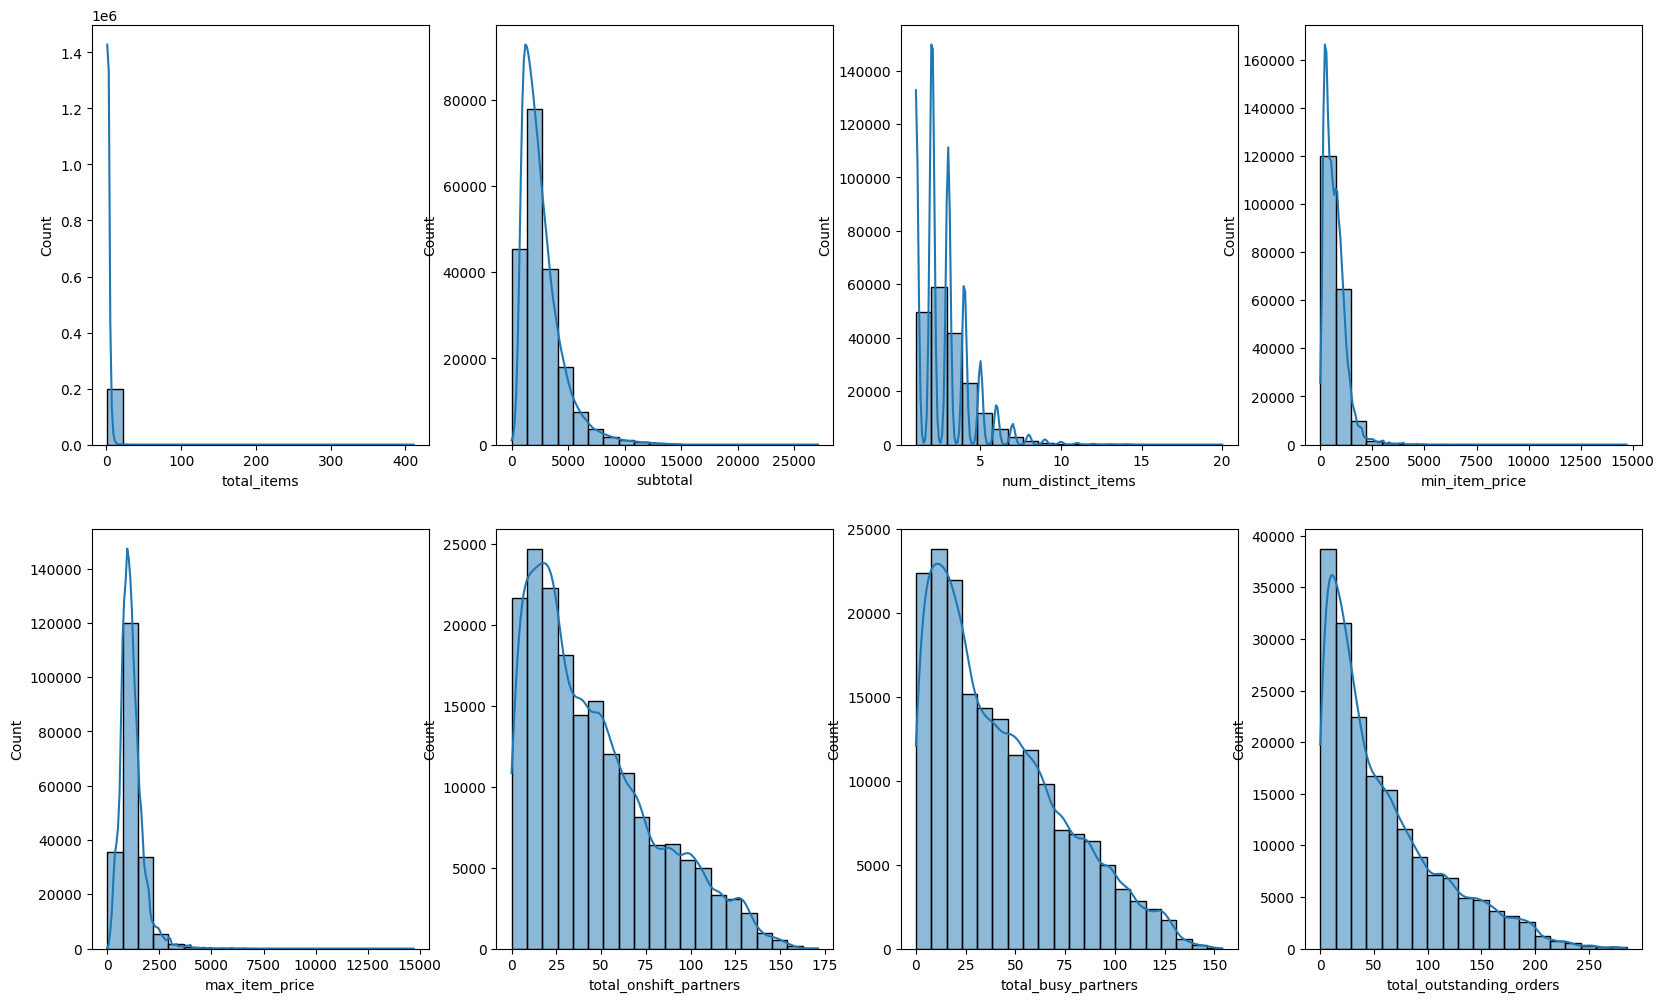

In [28]:

# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))

# Plot histograms for each variable in the specified subplots
sns.histplot(ax=ax1, x='total_items', data=df, kde=True, bins=20)
sns.histplot(ax=ax2, x='subtotal', data=df, kde=True, bins=20)
sns.histplot(ax=ax3, x='num_distinct_items', data=df, kde=True, bins=20)
sns.histplot(ax=ax4, x='min_item_price', data=df, kde=True, bins=20)
sns.histplot(ax=ax5, x='max_item_price', data=df, kde=True, bins=20)
sns.histplot(ax=ax6, x='total_onshift_partners', data=df, kde=True, bins=20)
sns.histplot(ax=ax7, x='total_busy_partners', data=df, kde=True, bins=20)
sns.histplot(ax=ax8, x='total_outstanding_orders', data=df, kde=True, bins=20)

# Display the plot
plt.show()

In [29]:
df.isna().sum()

store_primary_category       4758
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16261
total_busy_partners         16261
total_outstanding_orders    16261
Hour_of_day                     0
day_of_week                     0
del_time                        0
min_max_avg_item_price          0
dtype: int64

In [30]:
df['store_primary_category'].unique()

array(['american', 'mexican', nan, 'indian', 'italian', 'sandwich',
       'thai', 'cafe', 'salad', 'pizza', 'chinese', 'singaporean',
       'burger', 'breakfast', 'mediterranean', 'japanese', 'greek',
       'catering', 'filipino', 'convenience-store', 'other', 'korean',
       'vegan', 'asian', 'barbecue', 'fast', 'dessert', 'smoothie',
       'seafood', 'vietnamese', 'cajun', 'steak', 'middle-eastern',
       'soup', 'vegetarian', 'persian', 'nepalese', 'sushi',
       'latin-american', 'hawaiian', 'chocolate', 'burmese', 'british',
       'pasta', 'alcohol', 'dim-sum', 'peruvian', 'turkish', 'malaysian',
       'ethiopian', 'afghan', 'bubble-tea', 'german', 'french',
       'caribbean', 'gluten-free', 'comfort-food', 'gastropub',
       'pakistani', 'moroccan', 'spanish', 'southern', 'tapas', 'russian',
       'brazilian', 'european', 'cheese', 'african', 'argentine',
       'kosher', 'irish', 'lebanese', 'belgian', 'indonesian',
       'alcohol-plus-food'], dtype=object)

### Fixing Mixing Values 2

In [31]:
df.isna().sum()

store_primary_category       4758
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16261
total_busy_partners         16261
total_outstanding_orders    16261
Hour_of_day                     0
day_of_week                     0
del_time                        0
min_max_avg_item_price          0
dtype: int64

In [32]:
(df.total_onshift_partners==0).sum()

3612

In [33]:
df.store_primary_category.fillna(df.store_primary_category.mode()[0], inplace=True)

df.order_protocol.fillna(df.order_protocol.mean(), inplace=True)
df.total_onshift_partners.fillna(df.total_onshift_partners.mean(), inplace=True)
df.total_busy_partners.fillna(df.total_busy_partners.mean(), inplace=True)
df.total_outstanding_orders.fillna(df.total_outstanding_orders.mean(), inplace=True)

In [34]:
df['total_available_partners'] = df['total_onshift_partners']-df['total_busy_partners']

In [35]:
df.columns

Index(['store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'Hour_of_day', 'day_of_week', 'del_time',
       'min_max_avg_item_price', 'total_available_partners'],
      dtype='object')

### Encoding categorical columns

In [36]:
df['store_primary_category_probab'] = df['store_primary_category'].map(df['store_primary_category'].value_counts(1).to_dict())

df['order_protocol_probab'] = df['order_protocol'].map(df['order_protocol'].value_counts(1).to_dict())

In [37]:
df.drop(columns=['store_primary_category'], inplace=True)


## Data Visualization & cleaning

### Visualization - Countplots/ Scatterplots

In [38]:
categorical_cols.pop(categorical_cols.index('store_primary_category'))

'store_primary_category'

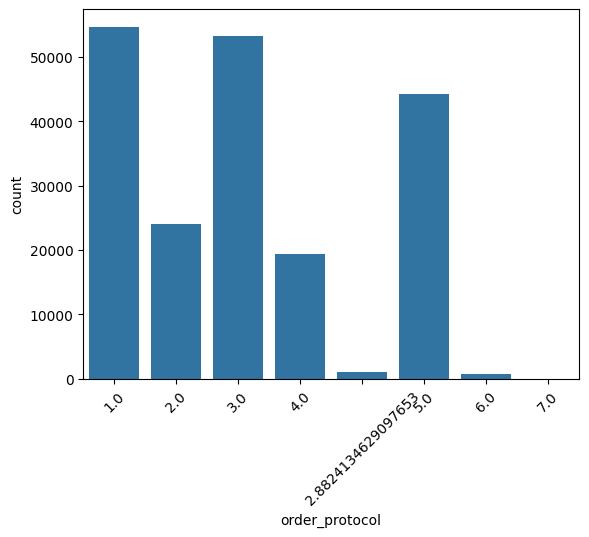

In [39]:
sns.countplot(x=df['order_protocol'].astype(str))
plt.xticks(rotation=45)
plt.show()

### Checking Outliers

In [40]:
df.describe()

,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week,del_time,min_max_avg_item_price,total_available_partners,store_primary_category_probab,order_protocol_probab
count,197327.000000,197327.000000,197327.000000,197327.000000,197327.000000,197327.000000,197327.000000,197327.000000,197327.000000,197327.000000,197327.000000,197327.000000,197327.000000,197327.000000,197327.000000,197327.000000
mean,2.882413,3.195792,2682.404800,2.670755,686.238898,1159.630714,44.825356,41.756161,58.074343,8.465603,3.218966,48.470055,922.934806,3.069196,0.052619,0.224273
std,1.499932,2.664255,1823.221543,1.630188,521.972270,558.387416,33.070846,30.790331,50.443212,8.658418,2.045769,320.569536,474.905620,10.942083,0.036005,0.067887
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.683333,0.000000,-64.000000,0.000005,0.000096
25%,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,19.000000,17.000000,19.000000,2.000000,1.000000,35.066667,624.500000,0.000000,0.027477,0.224379
50%,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,41.000000,39.000000,47.000000,3.000000,3.000000,44.333333,849.000000,2.000000,0.044444,0.269507
75%,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,62.000000,59.000000,80.000000,19.000000,5.000000,56.350000,1110.000000,5.000000,0.086633,0.277134
max,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,23.000000,6.000000,141947.650000,14700.000000,86.000000,0.122376,0.277134


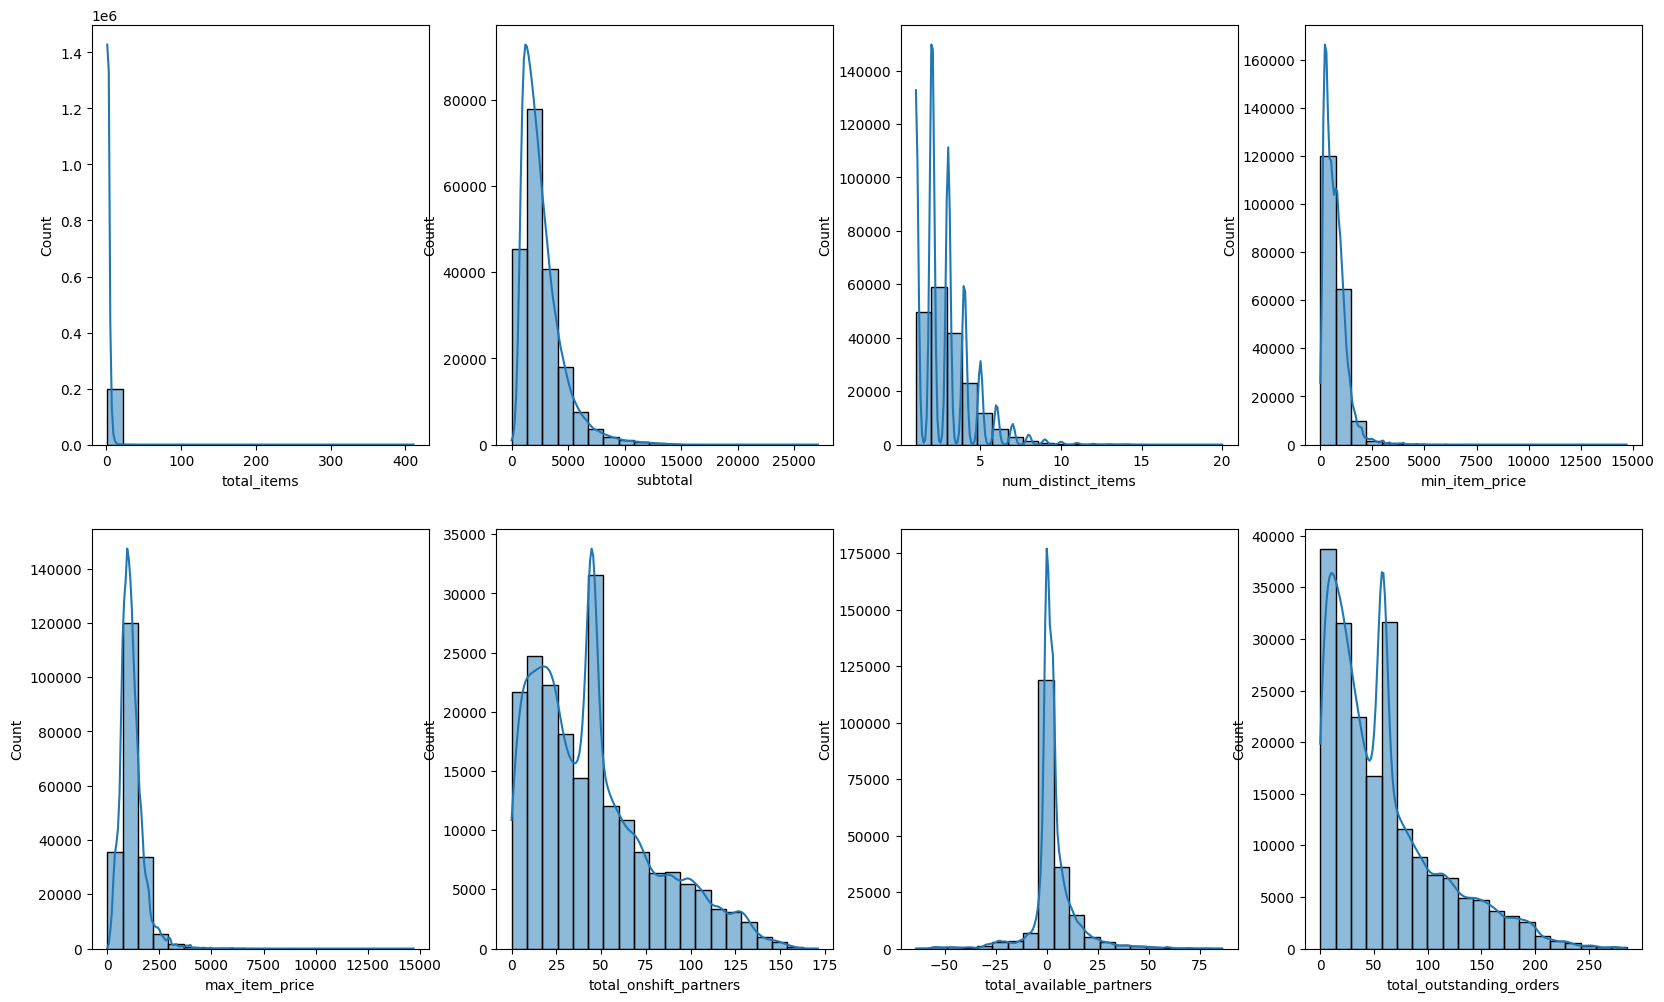

In [41]:
# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))

# Plot histograms for each variable in the specified subplots
sns.histplot(ax=ax1, x='total_items', data=df, kde=True, bins=20)
sns.histplot(ax=ax2, x='subtotal', data=df, kde=True, bins=20)
sns.histplot(ax=ax3, x='num_distinct_items', data=df, kde=True, bins=20)
sns.histplot(ax=ax4, x='min_item_price', data=df, kde=True, bins=20)
sns.histplot(ax=ax5, x='max_item_price', data=df, kde=True, bins=20)
sns.histplot(ax=ax6, x='total_onshift_partners', data=df, kde=True, bins=20)
sns.histplot(ax=ax7, x='total_available_partners', data=df, kde=True, bins=20)
sns.histplot(ax=ax8, x='total_outstanding_orders', data=df, kde=True, bins=20)

# Display the plot
plt.show()

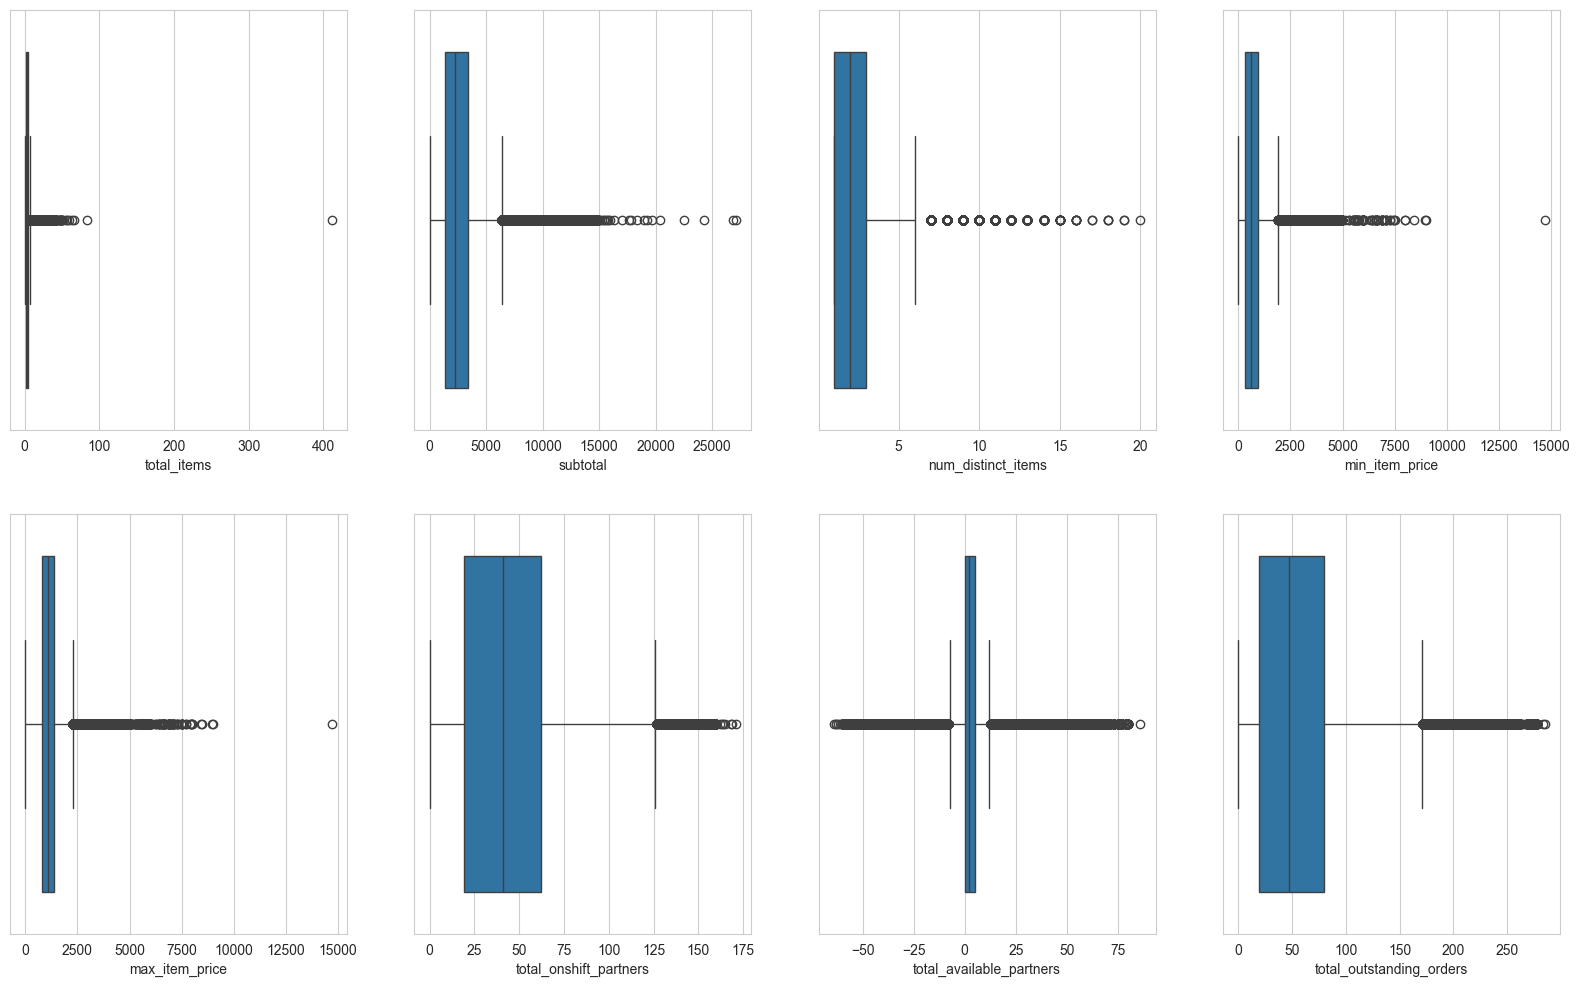

In [42]:
# Set the Seaborn style to 'whitegrid'
sns.set_style('whitegrid')

# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))

# Create box plots for each variable in the specified subplots
sns.boxplot(ax=ax1, x='total_items', data=df)
sns.boxplot(ax=ax2, x='subtotal', data=df)
sns.boxplot(ax=ax3, x='num_distinct_items', data=df)
sns.boxplot(ax=ax4, x='min_item_price', data=df)
sns.boxplot(ax=ax5, x='max_item_price', data=df)
sns.boxplot(ax=ax6, x='total_onshift_partners', data=df)
sns.boxplot(ax=ax7, x='total_available_partners', data=df)
sns.boxplot(ax=ax8, x='total_outstanding_orders', data=df)

# Display the plot
plt.show()

### Removing Outliers by IQR method

In [43]:
# Calculate the interquartile range (IQR) for each variable
Q1 = df[['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_available_partners', 'total_outstanding_orders']].quantile(0.25)
Q3 = df[['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_available_partners', 'total_outstanding_orders']].quantile(0.75)
IQR = Q3 - Q1

# Display the calculated IQR
print(IQR)

total_items                    2.0
subtotal                    1995.0
num_distinct_items             2.0
min_item_price               650.0
max_item_price               595.0
total_available_partners       5.0
total_outstanding_orders      61.0
dtype: float64


In [44]:
Lower = Q1-3.0*IQR
Upper = Q3+3.0*IQR

In [45]:
# Create boolean conditions for each variable using IQR boundaries
c0 = (df['total_items'] >= Lower['total_items']) & (df['total_items'] <= Upper['total_items'])
c1 = (df['subtotal'] >= Lower['subtotal']) & (df['subtotal'] <= Upper['subtotal'])
c2 = (df['num_distinct_items'] >= Lower['num_distinct_items']) & (df['num_distinct_items'] <= Upper['num_distinct_items'])
c3 = (df['min_item_price'] >= Lower['min_item_price']) & (df['min_item_price'] <= Upper['min_item_price'])
c4 = (df['max_item_price'] >= Lower['max_item_price']) & (df['max_item_price'] <= Upper['max_item_price'])
c5 = (df['total_available_partners'] >= Lower['total_available_partners']) & (df['total_available_partners'] <= Upper['total_available_partners'])
# c6 = (df['total_busy_partners'] >= Lower['total_busy_partners']) & (df['total_busy_partners'] <= Upper['total_busy_partners'])
c7 = (df['total_outstanding_orders'] >= Lower['total_outstanding_orders']) & (df['total_outstanding_orders'] <= Upper['total_outstanding_orders'])

# Filter the DataFrame based on the combined boolean conditions
df = df[c0 & c1 & c2 & c3 & c4 & c5 & c7]

# Display the updated shape of the DataFrame
print("Shape after outlier removal:", df.shape)

Shape after outlier removal: (173992, 16)


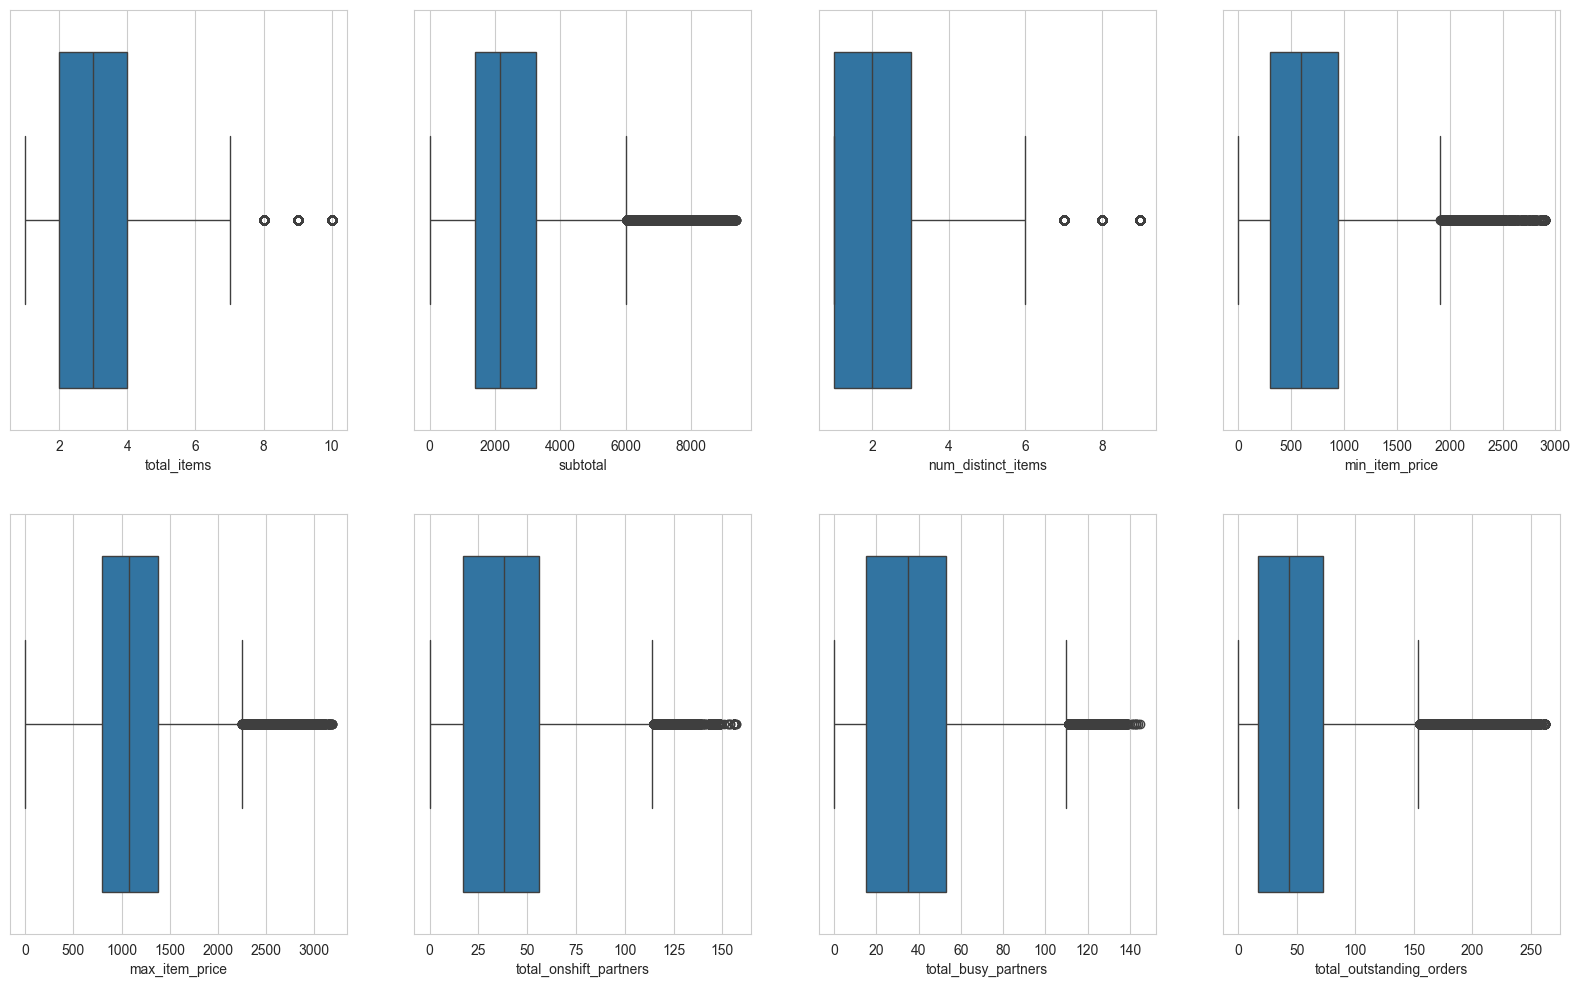

In [46]:
# Create a 2x4 grid of subplots with a specified figure size
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 12))

# Create box plots for each variable in the specified subplots
sns.boxplot(ax=ax1, x='total_items', data=df)
sns.boxplot(ax=ax2, x='subtotal', data=df)
sns.boxplot(ax=ax3, x='num_distinct_items', data=df)
sns.boxplot(ax=ax4, x='min_item_price', data=df)
sns.boxplot(ax=ax5, x='max_item_price', data=df)
sns.boxplot(ax=ax6, x='total_onshift_partners', data=df)
sns.boxplot(ax=ax7, x='total_busy_partners', data=df)
sns.boxplot(ax=ax8, x='total_outstanding_orders', data=df)

# Display the plot
plt.show()

In [47]:
# Select the columns containing numerical variables
numerical_df = df[numerical_cols]

numerical_df.skew()

total_items                   1.246039
subtotal                      1.349239
num_distinct_items            1.106239
min_item_price                1.114223
max_item_price                0.897860
total_onshift_partners        0.921712
total_busy_partners           0.932068
total_outstanding_orders      1.371046
del_time                    413.025300
dtype: float64

In [48]:
numerical_df.kurt()

total_items                      1.551892
subtotal                         2.023900
num_distinct_items               1.294796
min_item_price                   1.638290
max_item_price                   1.439973
total_onshift_partners           0.397894
total_busy_partners              0.424741
total_outstanding_orders         1.643074
del_time                    171684.766264
dtype: float64

In [49]:
df.columns

Index(['order_protocol', 'total_items', 'subtotal', 'num_distinct_items',
       'min_item_price', 'max_item_price', 'total_onshift_partners',
       'total_busy_partners', 'total_outstanding_orders', 'Hour_of_day',
       'day_of_week', 'del_time', 'min_max_avg_item_price',
       'total_available_partners', 'store_primary_category_probab',
       'order_protocol_probab'],
      dtype='object')

In [50]:
numerical_cols.extend(['store_primary_category_probab', 'order_protocol_probab', 'min_max_avg_item_price', 'total_available_partners', 'Hour_of_day', 'day_of_week', 'order_protocol'])



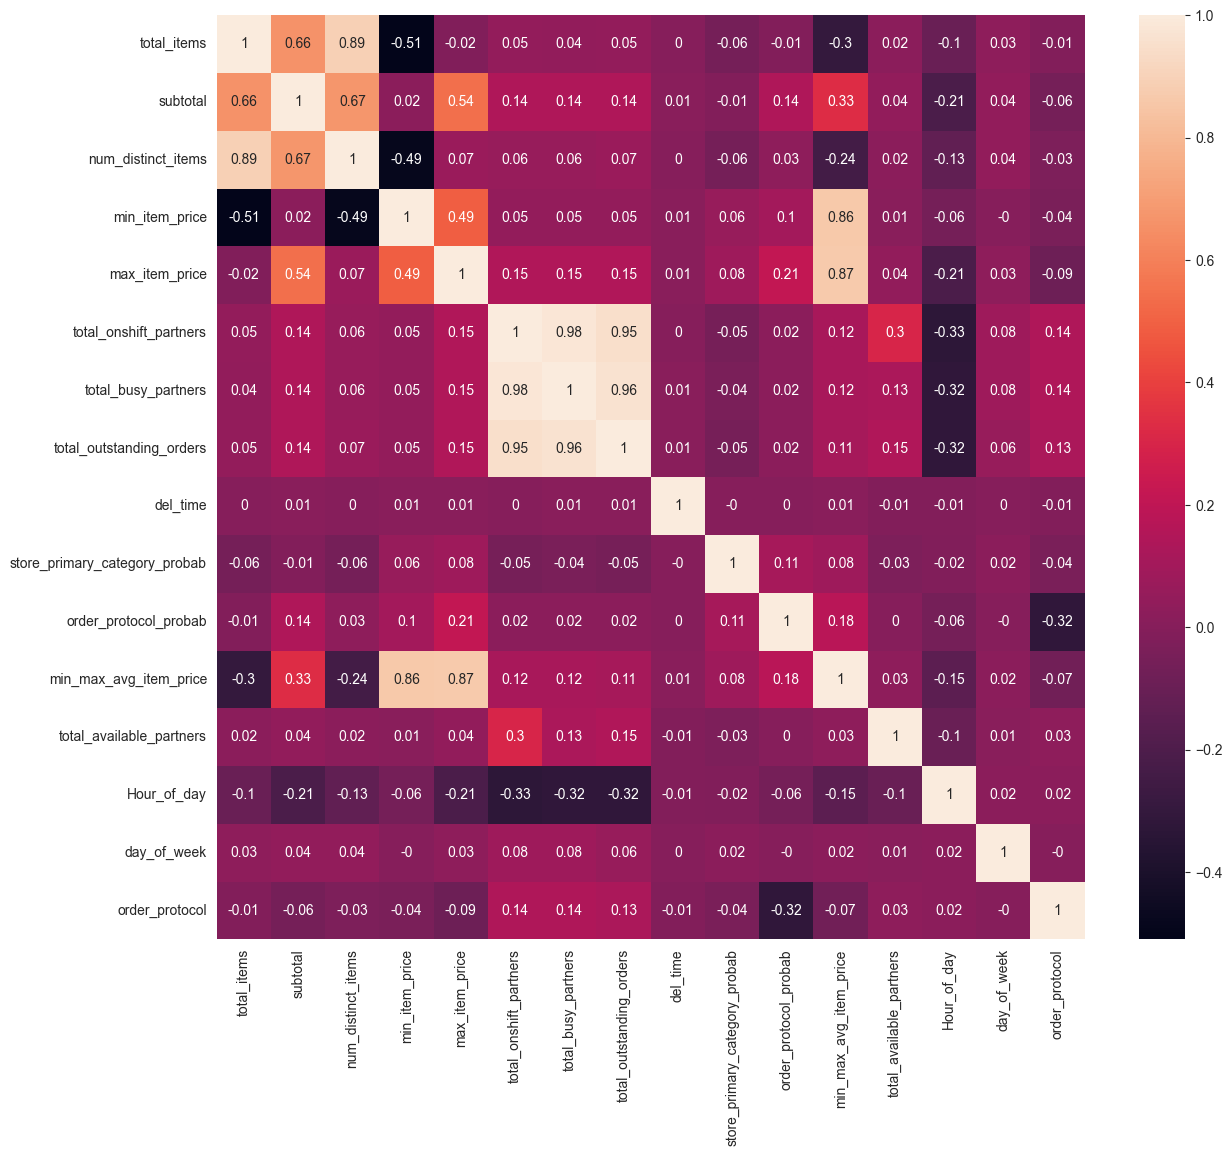

In [51]:

# Calculate and round the correlation matrix between the interval variables
correlation_matrix = df[numerical_cols].corr().round(2)

# Display the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [52]:
df.columns

Index(['order_protocol', 'total_items', 'subtotal', 'num_distinct_items',
       'min_item_price', 'max_item_price', 'total_onshift_partners',
       'total_busy_partners', 'total_outstanding_orders', 'Hour_of_day',
       'day_of_week', 'del_time', 'min_max_avg_item_price',
       'total_available_partners', 'store_primary_category_probab',
       'order_protocol_probab'],
      dtype='object')

### Split the data to train, val and test datasets

In [53]:
X = df.drop(columns=['del_time'])
y = df['del_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [54]:
df.head()

,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,Hour_of_day,day_of_week,del_time,min_max_avg_item_price,total_available_partners,store_primary_category_probab,order_protocol_probab
0,1.0,4,3441,4,557,1239,33.0,14.0,21.0,22,4,62.983333,898.0,19.0,0.122376,0.277134
1,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,21,1,67.066667,1400.0,-1.0,0.086633,0.121869
2,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,20,3,29.683333,1900.0,1.0,0.122376,0.277134
3,1.0,6,6900,5,600,1800,1.0,1.0,2.0,21,1,51.250000,1200.0,0.0,0.122376,0.277134
4,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,2,6,39.833333,1350.0,0.0,0.122376,0.277134


## Modeling

### Base Model

In [55]:
X.isna().sum()

order_protocol                   0
total_items                      0
subtotal                         0
num_distinct_items               0
min_item_price                   0
max_item_price                   0
total_onshift_partners           0
total_busy_partners              0
total_outstanding_orders         0
Hour_of_day                      0
day_of_week                      0
min_max_avg_item_price           0
total_available_partners         0
store_primary_category_probab    0
order_protocol_probab            0
dtype: int64

In [56]:
rf = RandomForestRegressor(max_depth=8, n_estimators=100, criterion='squared_error', random_state=42)

rf.fit(X_train, y_train)
feat_imp_series = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp_series.iloc[:10]

store_primary_category_probab    0.156637
Hour_of_day                      0.149846
min_item_price                   0.139788
total_busy_partners              0.115120
total_outstanding_orders         0.094030
subtotal                         0.093449
total_available_partners         0.074257
total_onshift_partners           0.047652
order_protocol                   0.036514
day_of_week                      0.031971
dtype: float64

In [57]:
y_pred = rf.predict(X_val)

metrics_evals(y_pred=y_pred, y_true=y_val, X_test=X_val)

# mse= 17276.82980714839
# rmse= 131.44135501107857
# mae= 13.725309712726052
# r2= -43.518131698823574

{'MSE': 16005.8005168076,
 'RMSE': 126.51403288492388,
 'MAE': 13.290489126209708,
 'R2': -43.821731644972324,
 'ADJ_R2': -43.86470824780246}

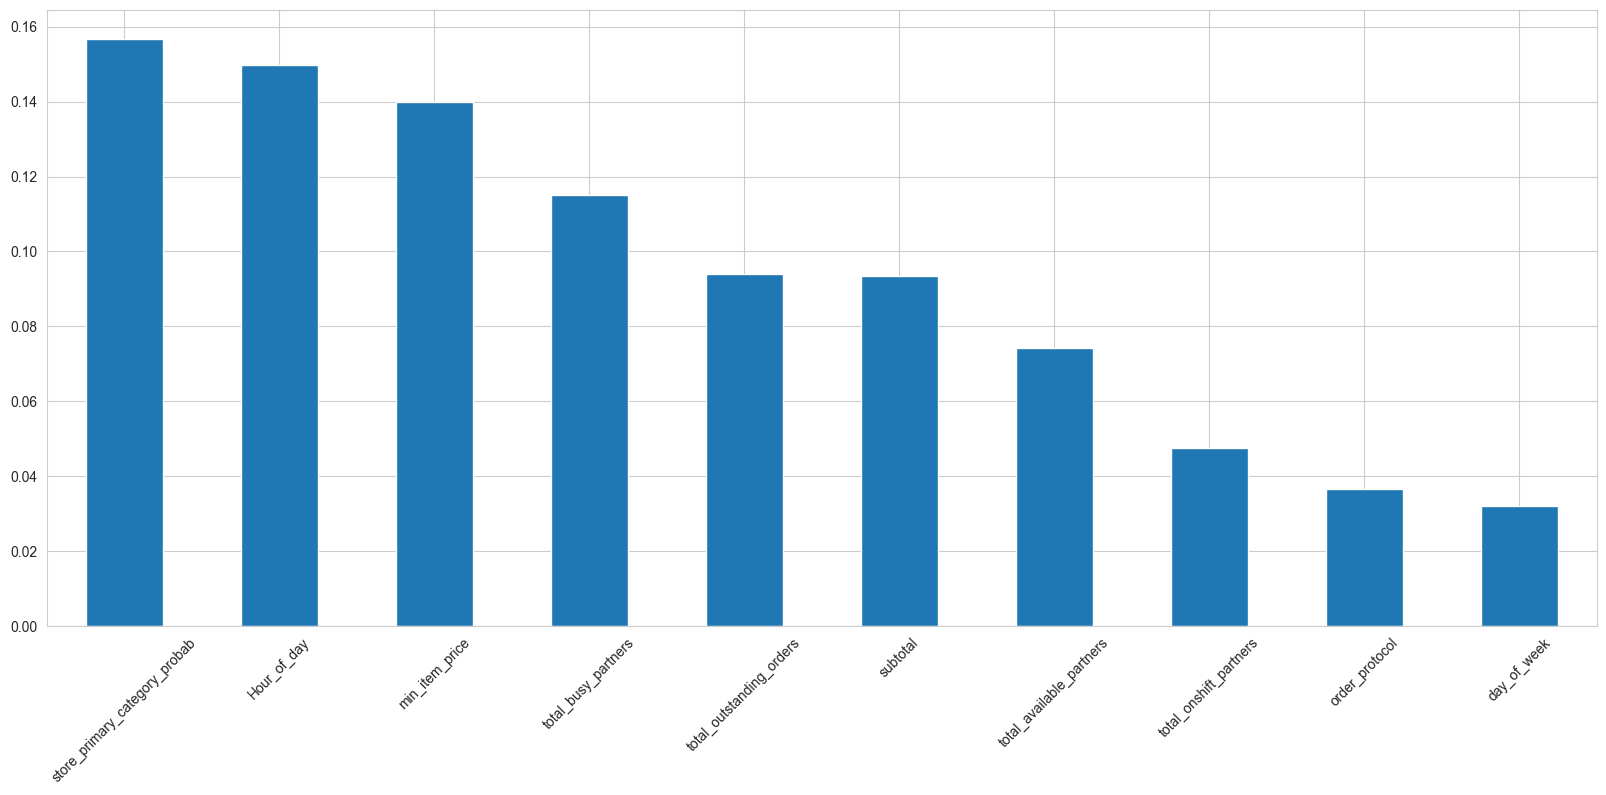

In [58]:

feat_imp_series.iloc[:10].plot(kind='bar',rot=45, figsize=(20,8))
plt.show()

- the delivery time is generally affected by the quantity of items to be delivered, its weight, its value (more value might need special packaging or may not), the rush during the time of delivery

### Scaling data for NN

In [59]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

### Simple NN Model

In [60]:
## Baseline Model Generator for NN

def create_baseline(activation_function='relu',
                    kernel_initializer='he_uniform'):

  # model = Sequential([
  #                   Dense(32, activation=activation_function,kernel_initializer='he_uniform'),
  #                   Dense(64, activation=activation_function,kernel_initializer='he_uniform'),
  #                   Dense(128, activation=activation_function,kernel_initializer='he_uniform'),
  #                   Dense(64, activation=activation_function,kernel_initializer='he_uniform'),
  #                   Dense(32, activation=activation_function,kernel_initializer='he_uniform'),
  #                   Dense(1, input_shape=(1,))])
  model = Sequential([
      Dense(64, activation=activation_function, kernel_initializer=kernel_initializer, input_shape=(X_train.shape[1],)),
      Dense(256,activation=activation_function, kernel_initializer=kernel_initializer),      
      Dense(512, activation=activation_function, kernel_initializer=kernel_initializer),
      Dense(256,activation=activation_function, kernel_initializer=kernel_initializer),
      Dense(64,activation=activation_function, kernel_initializer=kernel_initializer),      
      Dense(1,activation='linear') # Since it's a regression task, use 1 output neuron
  ])  
  return model

### Exploring Activation Functions

Epoch 1/50
508/508 - 4s - loss: 159691.7031 - mae: 14.9013 - mse: 159691.7031 - val_loss: 1060.4094 - val_mae: 22.2388 - val_mse: 1060.4094 - 4s/epoch - 8ms/step
Epoch 2/50
508/508 - 3s - loss: 159668.2812 - mae: 15.1292 - mse: 159668.2812 - val_loss: 379.6600 - val_mae: 12.6459 - val_mse: 379.6600 - 3s/epoch - 6ms/step
Epoch 3/50
508/508 - 3s - loss: 159663.7500 - mae: 14.7415 - mse: 159663.7500 - val_loss: 383.8314 - val_mae: 12.8522 - val_mse: 383.8314 - 3s/epoch - 6ms/step
Epoch 4/50
508/508 - 3s - loss: 159665.3594 - mae: 14.6809 - mse: 159665.3594 - val_loss: 438.8362 - val_mae: 14.0152 - val_mse: 438.8362 - 3s/epoch - 6ms/step
Epoch 5/50
508/508 - 3s - loss: 159637.5156 - mae: 14.9692 - mse: 159637.5156 - val_loss: 374.3677 - val_mae: 12.5379 - val_mse: 374.3677 - 3s/epoch - 6ms/step
Epoch 6/50
508/508 - 3s - loss: 159650.3594 - mae: 15.0072 - mse: 159650.3594 - val_loss: 385.2135 - val_mae: 12.4171 - val_mse: 385.2135 - 3s/epoch - 6ms/step
Epoch 7/50
508/508 - 3s - loss: 159650

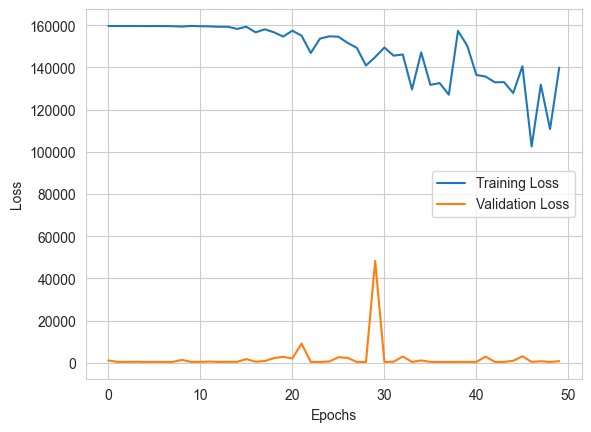

544/544 [==============================] - 1s 2ms/step - loss: 321.5107 - mae: 12.4681 - mse: 321.5107


ValueError: too many values to unpack (expected 2)

In [61]:
%%time
model = create_baseline(activation_function='relu', kernel_initializer='he_uniform')

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
history = model.fit(X_train, y_train, epochs=50, batch_size=250, validation_split=0.1, verbose=2)

y_pred = model.predict(X_test)

print(metrics_evals(y_pred=y_pred, y_true=y_test, X_test=X_test))


# Step 7: Plot the training loss and validation loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

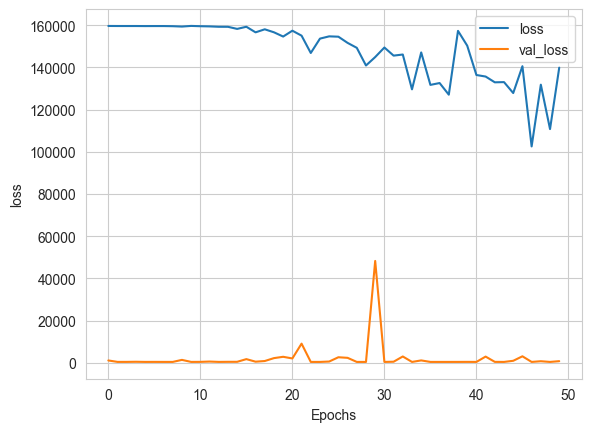

In [62]:
def plot_history(history,key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key,'val_'+key])
    plt.show()

# plot the history
plot_history(history=history,key='loss')

Epoch 1/50
508/508 - 5s - loss: 159765.6719 - mae: 16.5142 - mse: 159765.6719 - val_loss: 443.5211 - val_mae: 14.7287 - val_mse: 443.5211 - 5s/epoch - 9ms/step
Epoch 2/50
508/508 - 4s - loss: 159674.7812 - mae: 15.4139 - mse: 159674.7812 - val_loss: 437.7393 - val_mae: 14.0609 - val_mse: 437.7393 - 4s/epoch - 7ms/step
Epoch 3/50
508/508 - 3s - loss: 159673.4844 - mae: 15.2325 - mse: 159673.4844 - val_loss: 437.5456 - val_mae: 14.1012 - val_mse: 437.5456 - 3s/epoch - 7ms/step
Epoch 4/50
508/508 - 4s - loss: 159673.6094 - mae: 15.1232 - mse: 159673.6094 - val_loss: 451.3305 - val_mae: 15.1251 - val_mse: 451.3305 - 4s/epoch - 7ms/step
Epoch 5/50
508/508 - 3s - loss: 159672.8594 - mae: 15.3135 - mse: 159672.8594 - val_loss: 437.5568 - val_mae: 14.0979 - val_mse: 437.5568 - 3s/epoch - 7ms/step
Epoch 6/50
508/508 - 3s - loss: 159674.5000 - mae: 15.2076 - mse: 159674.5000 - val_loss: 437.8330 - val_mae: 14.0478 - val_mse: 437.8330 - 3s/epoch - 6ms/step
Epoch 7/50
508/508 - 3s - loss: 159673.5

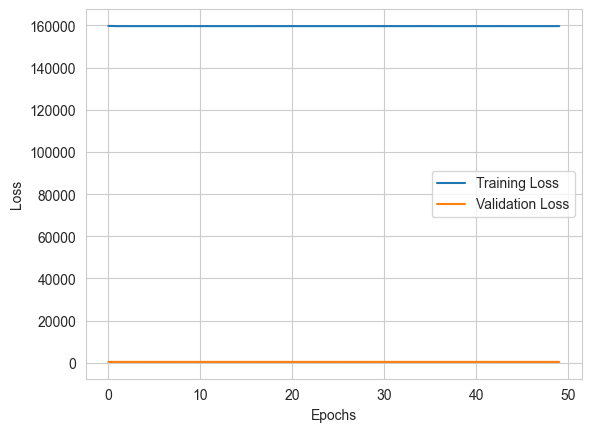

CPU times: user 10min 15s, sys: 2min 47s, total: 13min 3s
Wall time: 3min 9s


In [66]:
%%time

adam_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.99,
    name='Adam',
)


model1 = create_baseline(activation_function='tanh', kernel_initializer='glorot_uniform')

model1.compile(optimizer=adam_optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
history1 = model1.fit(X_train, y_train, epochs=50, batch_size=250, validation_split=0.1, verbose=2)

y_pred = model1.predict(X_test)

print(metrics_evals(y_pred=y_pred, y_true=y_test, X_test=X_test))


# Step 7: Plot the training loss and validation loss over epochs
import matplotlib.pyplot as plt

plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



Here's a comparison of the results between the Random Forest Regressor and the Simple Neural Network model:

**Random Forest Regressor:**


- Mean Squared Error (MSE): 16005.80
- Mean Absolute Error (MAE): 13.29
- R-squared (R2): -43.82



**Simple Neural Network Model (Best):**

- Mean Squared Error (MSE): 321.5109166532791
- Mean Absolute Error (MAE): 12.468098981433444
- R-squared (R2): 0.13218877933924755


**Comparison:**

The Random Forest Regressor has significantly higher MSE, MAE, and RMSE values compared to the Simple Neural Network model. This indicates that the Random Forest model performs better in terms of accuracy and error metrics.

The R-squared value for the Neural Network model is comparitvely better but it is still underfitting (0.928), indicating that it explains a some portion of the variance in the target variable.

In this specific scenario, the Random Forest Regressor might perform better upon passing standard normalized data. However, it's essential to consider that the performance of these models can vary depending on the dataset and problem we are working on. Further optimization and tuning of the neural network model may lead to improved results.

The given experimentation show cases of underfitting model.

In [ ]:
y_pred

array([[0.33334616, 0.33334535, 0.33330852],
       [0.33332938, 0.3333383 , 0.33333233],
       [0.3333248 , 0.3333387 , 0.33333656],
       ...,
       [0.3333264 , 0.3333375 , 0.33333609],
       [0.33332872, 0.33333597, 0.33333534],
       [0.33332178, 0.33334023, 0.33333805]], dtype=float32)

Epoch 1/100
635/635 [==============================] - 3s 3ms/step - loss: 162019.0781 - val_loss: 2707.3105
Epoch 2/100
635/635 [==============================] - 1s 2ms/step - loss: 162018.9219 - val_loss: 2707.3108
Epoch 3/100
635/635 [==============================] - 1s 2ms/step - loss: 162019.0156 - val_loss: 2707.3108
Epoch 4/100
635/635 [==============================] - 1s 2ms/step - loss: 162019.0625 - val_loss: 2707.3108
Epoch 5/100
635/635 [==============================] - 1s 2ms/step - loss: 162019.0156 - val_loss: 2707.3108
Epoch 6/100
635/635 [==============================] - 1s 2ms/step - loss: 162019.2656 - val_loss: 2707.3108
Epoch 7/100
635/635 [==============================] - 1s 2ms/step - loss: 162019.1406 - val_loss: 2707.3108
Epoch 8/100
635/635 [==============================] - 1s 2ms/step - loss: 162018.9219 - val_loss: 2707.3108
Epoch 9/100
635/635 [==============================] - 1s 2ms/step - loss: 162019.0469 - val_loss: 2707.3108
Epoch 10/100
635/63

In [ ]:
%%time
model = create_baseline(activation_function='tanh', final_activation='softmax')
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
model.fit(X_train, y_train, epochs=100, batch_size=200, validation_split=0.1, verbose=1)

Epoch 1/100
496/496 [==============================] - 3s 3ms/step - loss: 162019.0625 - val_loss: 2707.3113
Epoch 2/100
496/496 [==============================] - 1s 2ms/step - loss: 162019.0156 - val_loss: 2707.3113
Epoch 3/100
496/496 [==============================] - 1s 3ms/step - loss: 162019.1094 - val_loss: 2707.3113
Epoch 4/100
496/496 [==============================] - 1s 2ms/step - loss: 162019.0312 - val_loss: 2707.3113
Epoch 5/100
496/496 [==============================] - 1s 2ms/step - loss: 162018.9844 - val_loss: 2707.3113
Epoch 6/100
496/496 [==============================] - 1s 3ms/step - loss: 162019.1875 - val_loss: 2707.3113
Epoch 7/100
496/496 [==============================] - 1s 3ms/step - loss: 162019.1562 - val_loss: 2707.3113
Epoch 8/100
496/496 [==============================] - 1s 2ms/step - loss: 162019.2031 - val_loss: 2707.3113
Epoch 9/100
496/496 [==============================] - 1s 2ms/step - loss: 162019.0625 - val_loss: 2707.3113
Epoch 10/100
496/49